2025-06-29 21:39:00.848 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2025-06-29 21:39:00.852 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-29 21:39:00.852 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-29 21:39:00.852 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-29 21:39:00.853 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-29 21:39:00.926 
  command:

    streamlit run /opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-pac

EIDs in cov but not in processed_ids: set()
EIDs in processed_ids but not in cov: set()
Number of EIDs in cov: 400000
Number of EIDs in processed_ids: 400000
Number of overlapping EIDs: 400000
Number of unique individuals in statins: 78028
Number of people in df_drug: 78028
Number of people in both df_drug and cov: 68370
365845
34155
400000
0
0


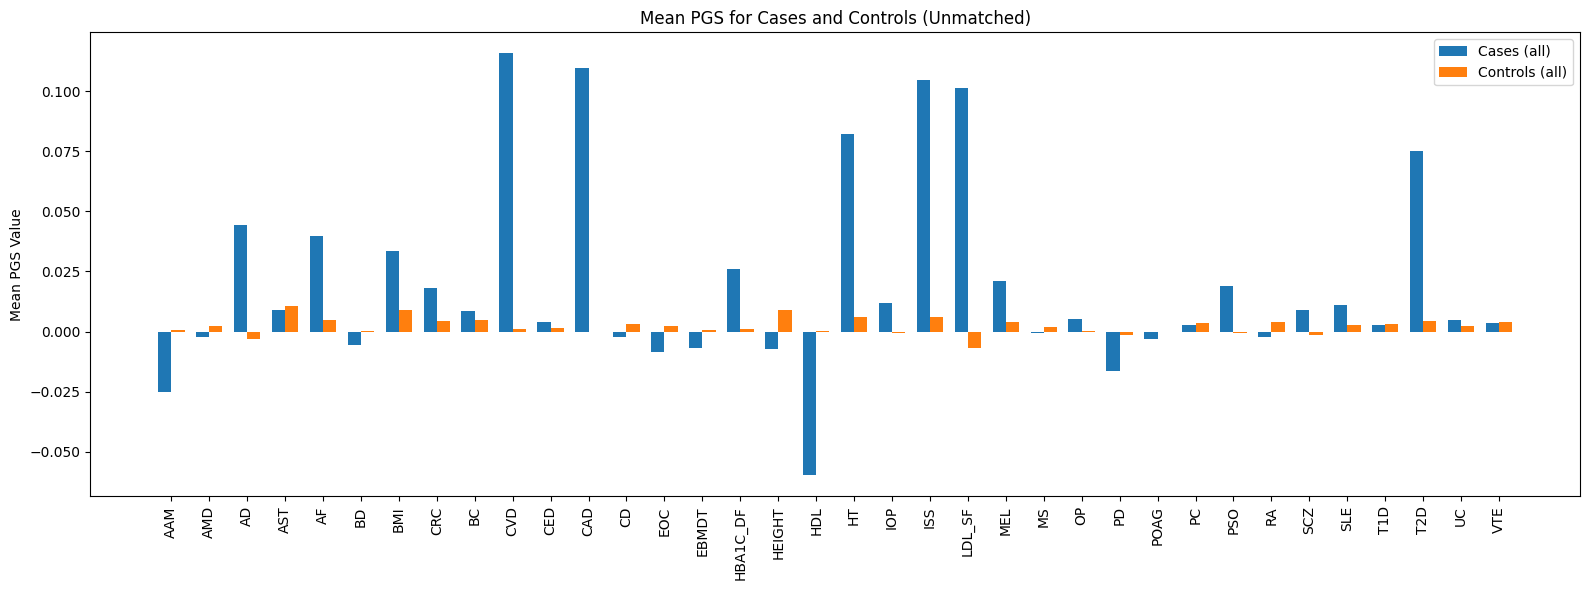

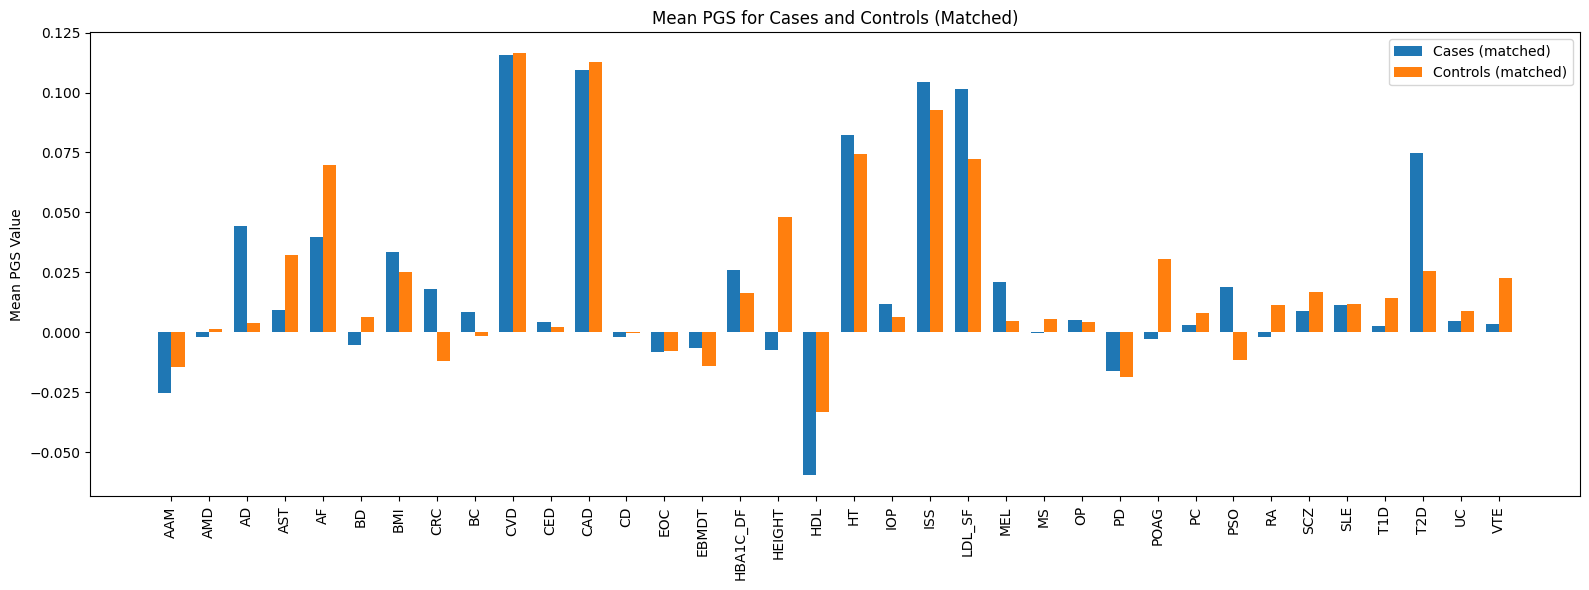

In [1]:
# Load cocde and do it for plotting 
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
from dt import *
import torch
import pandas as pd
# Set seeds
import random
random.seed(42)
np.random.seed(42)





# Load data (as in your code)
thetas = np.load("thetas.npy")
processed_ids = np.load("processed_patient_ids.npy").astype(int)

prs_names=pd.read_csv('prs_names.csv')
prs_labels = prs_names['Names'].tolist()


disease_names_df = pd.read_csv("disease_names.csv")
disease_names = disease_names_df.iloc[:, 1].tolist()
G = torch.load("/Users/sarahurbut/Library/CloudStorage/Dropbox/data_for_running/G_matrix.pt")
G = G.detach().cpu().numpy()
#covariate_path = '/Users/sarahurbut/Library/CloudStorage/Dropbox/for_regenie/ukbb_covariates_400k.txt'
cov=pd.read_csv('/Users/sarahurbut/aladynoulli2/pyScripts/matched_pce_df_400k.csv')
cov.columns = cov.columns.str.strip()
cov = cov.rename(columns={cov.columns[0]: 'eid'})
cov['eid'] = cov['eid'].astype(int)
cov['enrollment'] = pd.to_datetime(cov['Enrollment_Date'], errors='coerce')
cov['age_at_enroll'] = cov['enrollment'].dt.year - cov['birth_year']
age_at_enroll = dict(zip(cov['eid'], cov['age_at_enroll']))
eid_to_yob = dict(zip(cov['eid'], cov['birth_year']))

prescription_path = 'prescriptions.csv'
df_treat = pd.read_csv(prescription_path)
df_treat['eid'] = df_treat['eid'].astype(int)
df_treat = df_treat.merge(cov[['eid', 'birth_year']], on='eid', how='left')
df_treat['from'] = pd.to_datetime(df_treat['from'], errors='coerce')
time_grid = np.arange(thetas.shape[2])


# If processed_ids is not a pandas Series, convert it for convenience
processed_ids = pd.Series(processed_ids)

# Check if all cov['eid'] are in processed_ids and vice versa
cov_eids = set(cov['eid'])
processed_eids = set(processed_ids)

print("EIDs in cov but not in processed_ids:", cov_eids - processed_eids)
print("EIDs in processed_ids but not in cov:", processed_eids - cov_eids)
print("Number of EIDs in cov:", len(cov_eids))
print("Number of EIDs in processed_ids:", len(processed_eids))
print("Number of overlapping EIDs:", len(cov_eids & processed_eids))

drug_category = "statins"  # or "antidiabetic", etc.
df_drug = df_treat if drug_category == "All" else df_treat[df_treat['category'] == drug_category]
num_unique_eids = df_drug['eid'].nunique()
print(f"Number of unique individuals in {drug_category}: {num_unique_eids}")
# EIDs in df_treat and cov
treat_eids = set(df_drug['eid'])
overlap_treat_cov = treat_eids & cov_eids

print("Number of people in df_drug:", len(treat_eids))
print("Number of people in both df_drug and cov:", len(overlap_treat_cov))

# Only keep rows where statin start is after enrollment
# Find first statin prescription for each person
first_presc = df_drug.groupby('eid')['from'].min().reset_index()
first_presc = first_presc.merge(
    cov[['eid', 'Birthdate','Enrollment_Date']],
    left_on='eid', right_on='eid', how='left'
)

first_presc['Birthdate'] = pd.to_datetime(first_presc['Birthdate'])
first_presc['from'] = pd.to_datetime(first_presc['from'])

# Calculate age in years (including fraction)
first_presc['age_at_first_script'] = (first_presc['from'] - first_presc['Birthdate']).dt.days / 365.25
incident_treated = first_presc[first_presc['from'] > first_presc['Enrollment_Date']].copy()
incident_treated['age_at_first_script'] = (incident_treated['from'] - incident_treated['Birthdate']).dt.days/365.25
incident_treated['years_since_30'] = (incident_treated['age_at_first_script'] - 30).round()
incident_treated.shape

# Example usage:
prev_condition(cov, 'Dm_Any', 'Dm_censor_age', 'age_enrolled', 'prev_dm')
prev_condition(cov, 'DmT1_Any', 'DmT1_censor_age', 'age_enrolled', 'prev_dm1')
prev_condition(cov, 'Ht_Any', 'Ht_censor_age', 'age_enrolled', 'prev_ht')
prev_condition(cov, 'HyperLip_Any', 'HyperLip_censor_age', 'age_enrolled', 'prev_hl')

ldl_idx = prs_labels.index('LDL_SF')   # or whatever your LDL PRS is called
cad_idx = prs_labels.index('CAD')      # or whatever your CAD PRS is called
eid_to_dm2_prev = dict(zip(cov['eid'], cov['prev_dm']))
eid_to_antihtnbase = dict(zip(cov['eid'], cov['prev_ht']))
eid_to_htn = dict(zip(cov['eid'], cov['prev_ht']))
eid_to_smoke = dict(zip(cov['eid'], cov['SmokingStatusv2']))
eid_to_dm1_prev = dict(zip(cov['eid'], cov['prev_dm1']))
eid_to_hl_prev = dict(zip(cov['eid'], cov['prev_hl']))
eid_to_sex = dict(zip(cov['eid'],cov['Sex']))
eid_to_age=dict(zip(cov['eid'],cov['age_enrolled']))
eid_to_ldl_prs = {eid: G[i, ldl_idx] for i, eid in enumerate(processed_ids)}
eid_to_cad_prs = {eid: G[i, cad_idx] for i, eid in enumerate(processed_ids)}
eid_to_race=dict(zip(cov['eid'],cov['race']))
eid_to_pce_goff=dict(zip(cov['eid'],cov['pce_goff']))
eid_to_tchol=dict(zip(cov['eid'],cov['tchol']))
eid_to_hdl=dict(zip(cov['eid'],cov['hdl']))
eid_to_sbp=dict(zip(cov['eid'],cov['SBP']))

# Get timing and incident vs control ids
# For treated
treated_eids = incident_treated['eid']
treated_t0s = incident_treated['years_since_30']
treated_t0_dict = dict(zip(treated_eids, treated_t0s))
len(treated_t0_dict)
len(treated_eids)

# For controls
# (Assuming untreated_eids is a list of EIDs for controls)
treated_eids_set = set(incident_treated['eid'])
untreated_eids = [eid for eid in processed_ids if eid not in treated_eids_set]


# When selecting from covariate DataFrame:
controls_df = cov[cov['eid'].isin(untreated_eids)]

controls = cov[cov['eid'].isin(untreated_eids)].copy()
controls['years_since_30'] = (controls['age_enrolled'] - 30).round()
control_eids = controls['eid']
control_t0s = controls['years_since_30']
print(len(untreated_eids))
print(len(treated_eids_set))
print(len(untreated_eids)+len(treated_eids_set))
covariate_dicts = {
    'age_at_enroll': eid_to_age,
    'sex': eid_to_sex,
    'dm2_prev': eid_to_dm2_prev,
    'antihtnbase': eid_to_antihtnbase,
    'dm1_prev': eid_to_hl_prev,
    'smoke': eid_to_smoke,
    'ldl_prs': eid_to_ldl_prs,
    'cad_prs': eid_to_cad_prs,
    'tchol': eid_to_tchol,
    'hdl': eid_to_hdl,
    'sbp': eid_to_sbp,
    'pce_goff': eid_to_pce_goff
   
    
}
# Prepare lists of eids and t0s for treated and controls
from dt import *

treated_eids_list = list(treated_eids)
treated_t0s_list = list(treated_t0s)

control_eids_list = list(control_eids)
control_t0s_list = list(control_t0s)

# Build features
treated_features, treated_indices,treated_eids_matched = build_features(
    treated_eids_list, treated_t0s_list, processed_ids, thetas, covariate_dicts
)

control_features, control_indices,control_eids_matched = build_features(
    control_eids_list, control_t0s_list, processed_ids, thetas, covariate_dicts
)

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import numpy as np

# 1. Impute missing values on the raw features
imputer = SimpleImputer(strategy='mean')
all_features = np.vstack([treated_features, control_features])
imputer.fit(all_features)

treated_features_imputed = imputer.transform(treated_features)
control_features_imputed = imputer.transform(control_features)

# 2. Standardize the imputed features
scaler = StandardScaler().fit(np.vstack([treated_features_imputed, control_features_imputed]))
treated_features_std = scaler.transform(treated_features_imputed)
control_features_std = scaler.transform(control_features_imputed)

print(np.isnan(control_features_std).sum())
print(np.isnan(treated_features_std).sum())

from sklearn.neighbors import NearestNeighbors

nn = NearestNeighbors(n_neighbors=1, algorithm='auto').fit(control_features_std)
distances, indices = nn.kneighbors(treated_features_std)
matched_control_indices = [control_indices[i[0]] for i in indices]
matched_treated_indices = treated_indices  # these are the treateds you matched
matched_control_eids = [control_eids_matched[i] for i in indices.flatten()]
# G: shape (n_individuals, n_prs)
# G: shape (n_individuals, n_prs)

treated_indices = [np.where(processed_ids == int(eid))[0][0] for eid in treated_eids]
untreated_indices = [np.where(processed_ids == int(eid))[0][0] for eid in untreated_eids]


means_matched_cases = G[matched_treated_indices].mean(axis=0)
means_matched_controls = G[matched_control_indices].mean(axis=0)

means_unmatched_cases = G[treated_indices].mean(axis=0)
means_unmatched_controls = G[untreated_indices].mean(axis=0)

import numpy as np
import matplotlib.pyplot as plt

x = np.arange(len(prs_labels))
width = 0.35

fig, ax = plt.subplots(figsize=(16, 6))
ax.bar(x - width/2, means_unmatched_cases, width, label='Cases (all)')
ax.bar(x + width/2, means_unmatched_controls, width, label='Controls (all)')
ax.set_ylabel('Mean PGS Value')
ax.set_title('Mean PGS for Cases and Controls (Unmatched)')
ax.set_xticks(x)
ax.set_xticklabels(prs_labels, rotation=90)
ax.legend()
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(16, 6))
ax.bar(x - width/2, means_matched_cases, width, label='Cases (matched)')
ax.bar(x + width/2, means_matched_controls, width, label='Controls (matched)')
ax.set_ylabel('Mean PGS Value')
ax.set_title('Mean PGS for Cases and Controls (Matched)')
ax.set_xticks(x)
ax.set_xticklabels(prs_labels, rotation=90)
ax.legend()
plt.tight_layout()
plt.show()
import numpy as np
import matplotlib.pyplot as plt

def compute_smd(x1, x0):
    m1, m0 = np.nanmean(x1), np.nanmean(x0)
    s1, s0 = np.nanstd(x1), np.nanstd(x0)
    return np.abs(m1 - m0) / np.sqrt((s1**2 + s0**2) / 2)

smds_matched = []
for i, prs in enumerate(prs_labels):
    smds_matched.append(compute_smd(
        G[matched_treated_indices, i], G[matched_control_indices, i]
    ))

x = np.arange(len(prs_labels))
plt.figure(figsize=(16,6))
plt.bar(x, smds_matched, width=0.6)
plt.axhline(0.1, color='red', linestyle='--', label='SMD=0.1')
plt.xticks(x, prs_labels, rotation=90)
plt.ylabel('Standardized Mean Difference')
plt.title('SMD for PGS (Matched)')
plt.legend()
plt.tight_layout()
plt.show()
treated_eids = list(treated_eids)
groups = {
    'Treated (all)': cov[cov['eid'].isin(treated_eids_matched)],
    'Control (all)': cov[cov['eid'].isin(untreated_eids)],
    'Treated (matched)': cov[cov['eid'].isin(treated_eids_matched)],
    'Control (matched)': cov[cov['eid'].isin(matched_control_eids)],
    
}

print(groups['Treated (all)'].shape)
print(groups['Control (all)'].shape)
print(groups['Treated (matched)'].shape)
print(groups['Control (matched)'].shape)
len(matched_control_eids)

missing = set(matched_control_eids) - set(cov['eid'])
print(f"Number of missing matched control EIDs: {len(missing)}")
print(list(missing)[:10])  # Show a few examples

print(f"Number of unique matched_control_eids: {len(set(matched_control_eids))}")
print(f"Total matched_control_eids: {len(matched_control_eids)}")

categorical_covariates = ['Sex', 'SmokingStatusv2', 'prev_dm', 'prev_hl','race','antihtnbase']

for covariate in categorical_covariates:
    # Get all possible categories
    categories = set()
    for df in groups.values():
        categories.update(df[covariate].dropna().unique())
    categories = sorted(categories)
    cat_summary = pd.DataFrame(index=categories)
    for group_name, df in groups.items():
        cat_summary[group_name] = df[covariate].value_counts(normalize=True).reindex(categories, fill_value=0)
    print(f"\n{covariate} distribution table:")
    display(cat_summary.round(3))

categorical_covariates = ['Sex', 'SmokingStatusv2', 'prev_dm', 'prev_hl','race','antihtnbase']

for covariate in categorical_covariates:
    # Get all possible categories
    categories = set()
    for df in groups.values():
        categories.update(df[covariate].dropna().unique())
    categories = sorted(categories)
    cat_summary = pd.DataFrame(index=categories)
    for group_name, df in groups.items():
        cat_summary[group_name] = df[covariate].value_counts(normalize=True).reindex(categories, fill_value=0)
    print(f"\n{covariate} distribution table:")
    display(cat_summary.round(3))





covariates = ['age_at_enroll', 'tchol', 'hdl', 'SBP']
summary = pd.DataFrame(index=covariates)

groups = {
    'Treated (all)': cov[cov['eid'].isin(treated_eids_matched)],
    'Control (all)': cov[cov['eid'].isin(untreated_eids)],
    'Treated (matched)': cov[cov['eid'].isin(treated_eids_matched)],
    'Control (matched)': cov[cov['eid'].isin(matched_control_eids)],
}

for group_name, df in groups.items():
    summary[(group_name, 'mean')] = df[covariates].mean()
    summary[(group_name, 'std')] = df[covariates].std()

# Reorder columns for clarity
summary = summary.reindex(columns=pd.MultiIndex.from_product(
    [['Treated (all)', 'Control (all)', 'Treated (matched)', 'Control (matched)'], ['mean', 'std']]
))

# Display as a nice table
summary.round(2)


treated_matched=cov[cov['eid'].isin(treated_eids_matched)]
control_matched=cov[cov['eid'].isin(matched_control_eids)]

import numpy as np
import matplotlib.pyplot as plt

def compute_smd(x1, x0):
    m1, m0 = np.nanmean(x1), np.nanmean(x0)
    s1, s0 = np.nanstd(x1), np.nanstd(x0)
    return np.abs(m1 - m0) / np.sqrt((s1**2 + s0**2) / 2)

covariates = ['age_enrolled', 'tchol', 'hdl', 'SBP', 'pce_goff','Sex','prev_hl','prev_dm','antihtnbase']
smds_matched = []
for covariate in covariates:
    smds_matched.append(compute_smd(
        treated_matched[covariate], control_matched[covariate]
    ))

x = np.arange(len(covariates))
plt.figure(figsize=(8,4))
plt.bar(x, smds_matched, width=0.6)
plt.axhline(0.1, color='red', linestyle='--', label='SMD=0.1')
plt.xticks(x, covariates, rotation=45)
plt.ylabel('Standardized Mean Difference')
plt.title('SMD for Phenotypic Covariates (Matched)')
plt.legend()
plt.tight_layout()
plt.show()

# Print SMDs for reference
for covariate, smd in zip(covariates, smds_matched):
    print(f"{covariate}: SMD = {smd:.3f}")

In [ ]:
import pandas as pd

covariates = ['age_at_enroll', 'tchol', 'hdl', 'SBP']
summary = pd.DataFrame(index=covariates)

groups = {
    'Treated (all)': cov[cov['eid'].isin(treated_eids_matched)],
    'Control (all)': cov[cov['eid'].isin(untreated_eids)],
    'Treated (matched)': cov[cov['eid'].isin(treated_eids_matched)],
    'Control (matched)': cov[cov['eid'].isin(matched_control_eids)],
}

for group_name, df in groups.items():
    summary[(group_name, 'mean')] = df[covariates].mean()
    summary[(group_name, 'std')] = df[covariates].std()

# Reorder columns for clarity
summary = summary.reindex(columns=pd.MultiIndex.from_product(
    [['Treated (all)', 'Control (all)', 'Treated (matched)', 'Control (matched)'], ['mean', 'std']]
))

# Display as a nice table
summary.round(2)

In [309]:
treated_matched=cov[cov['eid'].isin(treated_eids_matched)]
control_matched=cov[cov['eid'].isin(matched_control_eids)]

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def compute_smd(x1, x0):
    m1, m0 = np.nanmean(x1), np.nanmean(x0)
    s1, s0 = np.nanstd(x1), np.nanstd(x0)
    return np.abs(m1 - m0) / np.sqrt((s1**2 + s0**2) / 2)

covariates = ['age_enrolled', 'tchol', 'hdl', 'SBP', 'pce_goff','Sex','prev_hl','prev_dm','antihtnbase']
smds_matched = []
for covariate in covariates:
    smds_matched.append(compute_smd(
        treated_matched[covariate], control_matched[covariate]
    ))

x = np.arange(len(covariates))
plt.figure(figsize=(8,4))
plt.bar(x, smds_matched, width=0.6)
plt.axhline(0.1, color='red', linestyle='--', label='SMD=0.1')
plt.xticks(x, covariates, rotation=45)
plt.ylabel('Standardized Mean Difference')
plt.title('SMD for Phenotypic Covariates (Matched)')
plt.legend()
plt.tight_layout()
plt.show()

# Print SMDs for reference
for covariate, smd in zip(covariates, smds_matched):
    print(f"{covariate}: SMD = {smd:.3f}")

In [ ]:
import pandas as pd

# Get DataFrames for matched treated and controls
treated_matched = pce_df.iloc[matched_treated_indices].copy()
control_matched = pce_df.iloc[matched_control_indices].copy()

# Add treatment indicator
treated_matched['treatment'] = 1
control_matched['treatment'] = 0

# Combine into one DataFrame
df_matched = pd.concat([treated_matched, control_matched], ignore_index=True)


# Create event indicator (1 = event, 0 = censored)
df_matched['event'] = (df_matched['Cad_hard_Any'] == 2).astype(int)
df_matched['time'] = df_matched['Cad_hard_censor_age']

In [ ]:
# For treated: merge in age_at_first_script
treated_t0_age = incident_treated.set_index('eid')['age_at_first_script']

# For controls: use age at enrollment
control_t0_age = pce_df.set_index('Identifier')['age']

# Add t0_age to df_matched
t0_ages = []
for idx, row in df_matched.iterrows():
    if row['treatment'] == 1:
        t0_ages.append(treated_t0_age.get(row['Identifier'], np.nan))
    else:
        t0_ages.append(control_t0_age.get(row['Identifier'], np.nan))
df_matched['t0_age'] = t0_ages

In [564]:
df_matched['t0_age'] = pd.to_numeric(df_matched['t0_age'], errors='coerce')

In [ ]:
# Only keep those whose CAD event (if any) is after t0, or who are censored before any event
df_matched = df_matched[
    (df_matched['Cad_hard_Any'] == 1) |  # No event
    (df_matched['Cad_hard_censor_age'] >= df_matched['t0_age'])  # Event/censoring after t0
].copy()

In [569]:
df_matched['time'] = df_matched['Cad_hard_censor_age'] - df_matched['t0_age']
df_matched['event'] = (
    (df_matched['Cad_hard_Any'] == 2) &
    (df_matched['Cad_hard_censor_age'] >= df_matched['t0_age'])
).astype(int)

In [ ]:
df_matched.shape

In [ ]:
df_matched.tail()

In [576]:
df_matched_clean = df_matched[df_matched['time'] > 0].copy()

In [ ]:
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

kmf = KaplanMeierFitter()
for label, group in df_matched_clean.groupby('treatment'):
    kmf.fit(group['time'], group['event'], label='Treated' if label==1 else 'Control')
    kmf.plot_survival_function()

plt.title('CAD-free Survival by Treatment')
plt.xlabel('Years since t0')
plt.ylabel('Survival Probability')
plt.legend()
plt.show()

In [ ]:
from lifelines import CoxPHFitter
cph = CoxPHFitter()
cph.fit(df_matched_clean[['time', 'event', 'treatment']], duration_col='time', event_col='event')
cph.print_summary()

In [ ]:
from dt import *
first_presc = df_drug.groupby('eid')['from'].min()
treated_time_idx = {}
for eid, presc_date in first_presc.items():
    yob = eid_to_yob.get(int(eid), None)
    t0 = get_time_index(yob, presc_date, time_grid)
    if t0 is not None:
        treated_time_idx[int(eid)] = t0
treated_eids = set(treated_time_idx.keys())
untreated_eids = [eid for eid in processed_ids if eid not in treated_eids]

# Parameters
window_post = 10

# Raw event rates (use full sets)
treated_events = 0
treated_total = 0
for eid, t0 in treated_time_idx.items():
    if t0 + window_post < Y.shape[2]:
        treated_total += 1
        idx = np.where(processed_ids == int(eid))[0][0]
        if np.any(Y[idx, disease_idx, t0:t0+window_post] > 0):
            treated_events += 1

untreated_events = 0
untreated_total = 0
for eid in untreated_eids:
    t0 = int(age_at_enroll.get(eid, 0) - 30)
    if t0 + window_post < Y.shape[2]:
        untreated_total += 1
        idx = np.where(processed_ids == int(eid))[0][0]
        if np.any(Y[idx, disease_idx, t0:t0+window_post] > 0):
            untreated_events += 1

raw_treated_rate = (treated_events / treated_total * 100) if treated_total > 0 else 0
raw_untreated_rate = (untreated_events / untreated_total * 100) if untreated_total > 0 else 0

print(f"Raw Treated Event Rate: {raw_treated_rate:.2f}% (n={treated_total})")
print(f"Raw Untreated Event Rate: {raw_untreated_rate:.2f}% (n={untreated_total})")

eid_to_sex = dict(zip(pce_df['id'], pce_df['Sex']))

match_result = run_digital_twin_matching(
    treated_time_idx,
    untreated_eids,
    processed_ids,
    thetas,
    Y,
    diabetes_idx=112,  # or your selected disease index
    window=10,
    window_post=10,
    sig_idx=None,
    
    max_cases=10000,
    age_at_enroll=age_at_enroll,
    age_tolerance=2,
    eid_to_sex=eid_to_sex,
    eid_to_dm2_prev=eid_to_dm2_prev,
    eid_to_antihtnbase=eid_to_antihtnbase,
    eid_to_dm1_prev=eid_to_dm1_prev,
)

# 5. Print results
print("Treated event rate:", match_result['treated_event_rate'])
print("Control event rate:", match_result['control_event_rate'])
print("Number of matched pairs:", len(match_result['matched_pairs']))

In [191]:
import pickle

with open('match_result.pkl', 'wb') as f:
    pickle.dump(match_result, f)

In [ ]:
disease_names[110:118]

In [ ]:
# List of disease indices to check (e.g., [diabetes_idx, athero_idx, ihd_idx])
disease_indices = [110,111,112,113,114,115,116,117,118]  # add more indices as needed

prior_event_eids = []
for eid, t0 in treated_time_idx.items():
    idx = np.where(processed_ids == int(eid))[0][0]
    # Check for any event in any of the diseases before t0
    if any(np.any(Y[idx, d_idx, :] > 0) for d_idx in disease_indices):
        prior_event_eids.append(eid)

print(f"Number of treated with prior event: {len(prior_event_eids)} out of {len(treated_time_idx)}")

In [ ]:
from dt import *
first_presc = df_drug.groupby('eid')['from'].min()
treated_time_idx = {}
for eid, presc_date in first_presc.items():
    yob = eid_to_yob.get(int(eid), None)
    t0 = get_time_index(yob, presc_date, time_grid)
    if t0 is not None:
        treated_time_idx[int(eid)] = t0
treated_eids = set(treated_time_idx.keys())
untreated_eids = [eid for eid in processed_ids if eid not in treated_eids]

# Parameters
window_post = 10

# Raw event rates (use full sets)
treated_events = 0
treated_total = 0
for eid, t0 in treated_time_idx.items():
    if t0 + window_post < Y.shape[2]:
        treated_total += 1
        idx = np.where(processed_ids == int(eid))[0][0]
        if np.any(Y[idx, disease_idx, t0:t0+window_post] > 0):
            treated_events += 1

untreated_events = 0
untreated_total = 0
for eid in untreated_eids:
    t0 = int(age_at_enroll.get(eid, 0) - 30)
    if t0 + window_post < Y.shape[2]:
        untreated_total += 1
        idx = np.where(processed_ids == int(eid))[0][0]
        if np.any(Y[idx, disease_idx, t0:t0+window_post] > 0):
            untreated_events += 1

raw_treated_rate = (treated_events / treated_total * 100) if treated_total > 0 else 0
raw_untreated_rate = (untreated_events / untreated_total * 100) if untreated_total > 0 else 0

print(f"Raw Treated Event Rate: {raw_treated_rate:.2f}% (n={treated_total})")
print(f"Raw Untreated Event Rate: {raw_untreated_rate:.2f}% (n={untreated_total})")

eid_to_sex = dict(zip(pce_df['id'], pce_df['Sex']))

match_result = run_digital_twin_matching(
    treated_time_idx,
    untreated_eids,
    processed_ids,
    thetas,
    Y,
    diabetes_idx=112,  # or your selected disease index
    window=10,
    window_post=10,
    sig_idx=None,
    
    max_cases=10000,
    age_at_enroll=age_at_enroll,
    age_tolerance=2,
    eid_to_sex=eid_to_sex,
    eid_to_dm2_prev=eid_to_dm2_prev,
    eid_to_antihtnbase=eid_to_antihtnbase,
    eid_to_dm1_prev=eid_to_dm1_prev,
)

# 5. Print results
print("Treated event rate:", match_result['treated_event_rate'])
print("Control event rate:", match_result['control_event_rate'])
print("Number of matched pairs:", len(match_result['matched_pairs']))

In [138]:
prs_names=pd.read_csv('prs_names.csv')
prs_labels = prs_names['Names'].tolist()
# Unmatched
treated_indices = [np.where(processed_ids == int(eid))[0][0] for eid in treated_eids]
untreated_indices = [np.where(processed_ids == int(eid))[0][0] for eid in untreated_eids]

# Matched
matched_treated_indices = [pair[0] for pair in match_result['matched_pairs']]
matched_control_indices = [pair[1] for pair in match_result['matched_pairs']]

means_unmatched_cases = G[treated_indices].mean(axis=0)
means_unmatched_controls = G[untreated_indices].mean(axis=0)
means_matched_cases = G[matched_treated_indices].mean(axis=0)
means_matched_controls = G[matched_control_indices].mean(axis=0)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

x = np.arange(len(prs_labels))  # 36 PRS
width = 0.35  # width of the bars

# Unmatched
fig, ax = plt.subplots(figsize=(16, 6))
rects1 = ax.bar(x - width/2, means_unmatched_cases, width, label='Cases (all)')
rects2 = ax.bar(x + width/2, means_unmatched_controls, width, label='Controls (all)')
ax.set_ylabel('Mean PGS Value')
ax.set_title('Mean PGS for Cases and Controls (Unmatched)')
ax.set_xticks(x)
ax.set_xticklabels(prs_labels, rotation=90)
ax.legend()
plt.tight_layout()
plt.show()

# Matched
fig, ax = plt.subplots(figsize=(16, 6))
rects1 = ax.bar(x - width/2, means_matched_cases, width, label='Cases (matched)')
rects2 = ax.bar(x + width/2, means_matched_controls, width, label='Controls (matched)')
ax.set_ylabel('Mean PGS Value')
ax.set_title('Mean PGS for Cases and Controls (Matched)')
ax.set_xticks(x)
ax.set_xticklabels(prs_labels, rotation=90)
ax.legend()
plt.tight_layout()
plt.show()

In [140]:
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
pandas2ri.activate()

# Load the RDS file
readRDS = robjects.r['readRDS']
pce_data = readRDS('/Users/sarahurbut/Library/CloudStorage/Dropbox/pce_df_prevent.rds')
pce_df = pandas2ri.rpy2py(pce_data)  # Convert to pandas DataFrame

In [141]:
pce_df=pd.read_csv('/Users/sarahurbut/Library/CloudStorage/Dropbox/pce_zy_2.csv')

In [142]:
# Convert matched indices to IDs
matched_treated_ids = [processed_ids[idx] for idx in [pair[0] for pair in match_result['matched_pairs']]]
matched_control_ids = [processed_ids[idx] for idx in [pair[1] for pair in match_result['matched_pairs']]]

In [143]:
# Unmatched
treated_unmatched = pce_df[pce_df['id'].isin(treated_eids)]
untreated_unmatched = pce_df[pce_df['id'].isin(untreated_eids)]

# Matched
treated_matched = pce_df[pce_df['id'].isin(matched_treated_ids)]
control_matched = pce_df[pce_df['id'].isin(matched_control_ids)]

In [ ]:
import pandas as pd

covariates = ['age', 'tchol', 'hdl', 'SBP', 'pce_goff']
summary = pd.DataFrame(index=covariates)

groups = {
    'Treated (all)': treated_unmatched,
    'Control (all)': untreated_unmatched,
    'Treated (matched)': treated_matched,
    'Control (matched)': control_matched
}

for group_name, df in groups.items():
    summary[(group_name, 'mean')] = df[covariates].mean()
    summary[(group_name, 'std')] = df[covariates].std()

# Reorder columns for clarity
summary = summary.reindex(columns=pd.MultiIndex.from_product(
    [['Treated (all)', 'Control (all)', 'Treated (matched)', 'Control (matched)'], ['mean', 'std']]
))

# Display as a nice table
summary.round(2)

In [ ]:
categorical_covariates = ['race', 'Sex', 'SmokingStatusv2','dm2_prev',"antihtnbase",'dm1_prev']

for cov in categorical_covariates:
    # Get all possible categories
    categories = set(
        treated_unmatched[cov].dropna().unique().tolist() +
        untreated_unmatched[cov].dropna().unique().tolist() +
        treated_matched[cov].dropna().unique().tolist() +
        control_matched[cov].dropna().unique().tolist()
    )
    cat_summary = pd.DataFrame(index=sorted(categories))
    for group_name, df in groups.items():
        cat_summary[group_name] = df[cov].value_counts(normalize=True).reindex(categories, fill_value=0)
    print(f"\n{cov} distribution table:")
    display(cat_summary.round(3))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Data from your summary
covariates = ['age', 'tchol', 'hdl', 'SBP', 'pce_goff']
group_labels = ['Treated (all)', 'Control (all)', 'Treated (matched)', 'Control (matched)']
means = [
    [60.63, 213.60, 51.81, 145.62, 0.127],   # Treated (all)
    [56.61, 220.84, 56.51, 139.18, 0.077],   # Control (all)
    [60.75, 213.24, 51.79, 145.72, 0.127],   # Treated (matched)
    [60.61, 223.17, 56.58, 142.84, 0.103],   # Control (matched)
]
stds = [
    [6.48, 52.46, 13.88, 19.61, 0.084],      # Treated (all)
    [8.03, 42.89, 14.82, 19.57, 0.070],      # Control (all)
    [6.43, 52.38, 13.83, 19.50, 0.084],      # Treated (matched)
    [6.41, 45.03, 15.16, 19.85, 0.074],      # Control (matched)
]

means = np.array(means)
stds = np.array(stds)

x = np.arange(len(covariates))
width = 0.2

fig, ax = plt.subplots(figsize=(12, 6))
for i in range(4):
    ax.bar(x + (i-1.5)*width, means[i], width, yerr=stds[i], capsize=5, label=group_labels[i])

ax.set_xticks(x)
ax.set_xticklabels(covariates, rotation=45)
ax.set_ylabel('Mean (with std error bars)')
ax.set_title('Covariate Means and Standard Deviations by Group')
ax.legend()
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Indices for each group
treated_indices = [np.where(processed_ids == int(eid))[0][0] for eid in treated_eids]
untreated_indices = [np.where(processed_ids == int(eid))[0][0] for eid in untreated_eids]
matched_treated_indices = [pair[0] for pair in match_result['matched_pairs']]
matched_control_indices = [pair[1] for pair in match_result['matched_pairs']]

# Calculate means and stds for each PGS
means = {
    'Treated (all)': G[treated_indices].mean(axis=0),
    'Control (all)': G[untreated_indices].mean(axis=0),
    'Treated (matched)': G[matched_treated_indices].mean(axis=0),
    'Control (matched)': G[matched_control_indices].mean(axis=0),
}
stds = {
    'Treated (all)': G[treated_indices].std(axis=0),
    'Control (all)': G[untreated_indices].std(axis=0),
    'Treated (matched)': G[matched_treated_indices].std(axis=0),
    'Control (matched)': G[matched_control_indices].std(axis=0),
}

# Plot means for all 36 PGS
plt.figure(figsize=(14, 6))
for label, mean in means.items():
    plt.plot(range(36), mean, marker='o', label=label)
plt.xlabel('PGS Index')
plt.ylabel('Mean PGS Value')
plt.title('Mean of Each PGS Before and After Matching')
plt.legend()
plt.show()

# Optionally, plot standard deviations
plt.figure(figsize=(14, 6))
for label, std in stds.items():
    plt.plot(range(36), std, marker='o', label=label)
plt.xlabel('PGS Index')
plt.ylabel('Std of PGS Value')
plt.title('Std of Each PGS Before and After Matching')
plt.legend()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression

# 1. Build treatment indicator and covariate DataFrame
all_eids = np.concatenate([list(treated_time_idx.keys()), untreated_eids])
treatment = np.array([1]*len(treated_time_idx) + [0]*len(untreated_eids))

covariate_cols = ['sex', 'age_at_enroll'] + [f'PC{i}' for i in range(1, 21)]  # adjust as needed
cov_df = cov.set_index('eid').loc[all_eids, covariate_cols].reset_index()
cov_df['treatment'] = treatment

# 2. Fit propensity score model
X = cov_df[covariate_cols].values
y = cov_df['treatment'].values
ps_model = LogisticRegression(max_iter=1000)
ps_model.fit(X, y)
cov_df['ps'] = ps_model.predict_proba(X)[:,1]

# 3. Compute IPW weights
cov_df['weight'] = np.where(
    cov_df['treatment'] == 1,
    1 / cov_df['ps'],
    1 / (1 - cov_df['ps'])
)

# 4. For each individual, get event in post-treatment window
eid_to_idx = {eid: np.where(processed_ids == eid)[0][0] for eid in all_eids}
window_post = 10
event_col = []
for i, row in cov_df.iterrows():
    eid = row['eid']
    treat = row['treatment']
    if treat == 1:
        t0 = treated_time_idx[eid]
    else:
        t0 = int(age_at_enroll.get(eid, 0) - 30)
    idx = eid_to_idx[eid]
    if t0 + window_post < Y.shape[2]:
        event = int(np.any(Y[idx, disease_idx, t0:t0+window_post] > 0))
    else:
        event = np.nan
    event_col.append(event)
cov_df['event'] = event_col

# 5. Weighted event rates
treated_mask = (cov_df['treatment'] == 1) & (~cov_df['event'].isna())
untreated_mask = (cov_df['treatment'] == 0) & (~cov_df['event'].isna())

weighted_treated_rate = np.sum(cov_df.loc[treated_mask, 'event'] * cov_df.loc[treated_mask, 'weight']) / np.sum(cov_df.loc[treated_mask, 'weight'])
weighted_untreated_rate = np.sum(cov_df.loc[untreated_mask, 'event'] * cov_df.loc[untreated_mask, 'weight']) / np.sum(cov_df.loc[untreated_mask, 'weight'])

print(f"IPW Treated Event Rate: {weighted_treated_rate*100:.2f}%")
print(f"IPW Untreated Event Rate: {weighted_untreated_rate*100:.2f}%")

In [ ]:
import numpy as np
import pandas as pd
del disease_idx

# Set seeds
import random
random.seed(42)
np.random.seed(42)

# Load data (as in your code)
thetas = np.load("thetas.npy")
processed_ids = np.load("processed_patient_ids.npy").astype(int)
try:
    Y = np.load("Y.npy")
except Exception:
    import torch
    Y = torch.load("/Users/sarahurbut/Library/CloudStorage/Dropbox/data_for_running/Y_tensor.pt")
    if hasattr(Y, 'detach'):
        Y = Y.detach().cpu().numpy()

disease_names_df = pd.read_csv("disease_names.csv")
disease_names = disease_names_df.iloc[:, 1].tolist()
disease_name = "Myocardial infarction"  # or your disease of interest
print(disease_name)
disease_idx = disease_names.index(disease_name)
print(disease_idx)
covariate_path = '/Users/sarahurbut/Library/CloudStorage/Dropbox/for_regenie/ukbb_covariates_400k.txt'
cov = pd.read_csv(covariate_path, sep=' ')
cov.columns = cov.columns.str.strip()
cov = cov.rename(columns={cov.columns[0]: 'eid', cov.columns[2]: 'year_of_birth'})
cov['eid'] = cov['eid'].astype(int)
cov['enrollment'] = pd.to_datetime(cov['enrollment'], errors='coerce')
cov['age_at_enroll'] = cov['enrollment'].dt.year - cov['year_of_birth']
age_at_enroll = dict(zip(cov['eid'], cov['age_at_enroll']))
eid_to_yob = dict(zip(cov['eid'], cov['year_of_birth']))

prescription_path = 'prescriptions.csv'
df_treat = pd.read_csv(prescription_path)
df_treat['eid'] = df_treat['eid'].astype(int)
df_treat = df_treat.merge(cov[['eid', 'year_of_birth']], on='eid', how='left')
df_treat['from'] = pd.to_datetime(df_treat['from'], errors='coerce')
time_grid = np.arange(thetas.shape[2])
def get_time_index(yob, presc_date, time_grid):
    if pd.isnull(yob) or pd.isnull(presc_date):
        return None
    if isinstance(presc_date, str):
        presc_date = pd.to_datetime(presc_date, errors='coerce')
    if pd.isnull(presc_date):
        return None
    age_at_presc = presc_date.year - yob
    return int(np.argmin(np.abs(time_grid + 30 - age_at_presc)))
first_presc = df_treat.groupby('eid')['from'].min()
treated_time_idx = {}
for eid, presc_date in first_presc.items():
    yob = eid_to_yob.get(int(eid), None)
    t0 = get_time_index(yob, presc_date, time_grid)
    if t0 is not None:
        treated_time_idx[int(eid)] = t0
treated_eids = set(treated_time_idx.keys())
untreated_eids = [eid for eid in processed_ids if eid not in treated_eids]

# Parameters
window_post = 10

# Raw event rates (use full sets)
treated_events = 0
treated_total = 0
for eid, t0 in treated_time_idx.items():
    if t0 + window_post < Y.shape[2]:
        treated_total += 1
        idx = np.where(processed_ids == int(eid))[0][0]
        if np.any(Y[idx, disease_idx, t0:t0+window_post] > 0):
            treated_events += 1

untreated_events = 0
untreated_total = 0
for eid in untreated_eids:
    t0 = int(age_at_enroll.get(eid, 0) - 30)
    if t0 + window_post < Y.shape[2]:
        untreated_total += 1
        idx = np.where(processed_ids == int(eid))[0][0]
        if np.any(Y[idx, disease_idx, t0:t0+window_post] > 0):
            untreated_events += 1

raw_treated_rate = (treated_events / treated_total * 100) if treated_total > 0 else 0
raw_untreated_rate = (untreated_events / untreated_total * 100) if untreated_total > 0 else 0

print(f"Raw Treated Event Rate: {raw_treated_rate:.2f}% (n={treated_total})")
print(f"Raw Untreated Event Rate: {raw_untreated_rate:.2f}% (n={untreated_total})")

match_result = run_digital_twin_matching(
    treated_time_idx,
    untreated_eids,
    processed_ids,
    thetas,
    Y,
    diabetes_idx=disease_idx,  # or your selected disease index
    window=10,
    window_post=10,
    sig_idx=None,
    sample_size=1000,
    max_cases=100,
    age_at_enroll=age_at_enroll,
    age_tolerance=2,
    eid_to_sex=None)
# 5. Print results
print("Treated event rate:", match_result['treated_event_rate'])
print("Control event rate:", match_result['control_event_rate'])
print("Number of matched pairs:", len(match_result['matched_pairs']))

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression

# 1. Build treatment indicator and covariate DataFrame
all_eids = np.concatenate([list(treated_time_idx.keys()), untreated_eids])
treatment = np.array([1]*len(treated_time_idx) + [0]*len(untreated_eids))

covariate_cols = ['sex', 'age_at_enroll'] + [f'PC{i}' for i in range(1, 21)]  # adjust as needed
cov_df = cov.set_index('eid').loc[all_eids, covariate_cols].reset_index()
cov_df['treatment'] = treatment

# 2. Fit propensity score model
X = cov_df[covariate_cols].values
y = cov_df['treatment'].values
ps_model = LogisticRegression(max_iter=1000)
ps_model.fit(X, y)
cov_df['ps'] = ps_model.predict_proba(X)[:,1]

# 3. Compute IPW weights
cov_df['weight'] = np.where(
    cov_df['treatment'] == 1,
    1 / cov_df['ps'],
    1 / (1 - cov_df['ps'])
)

# 4. For each individual, get event in post-treatment window
eid_to_idx = {eid: np.where(processed_ids == eid)[0][0] for eid in all_eids}
window_post = 10
event_col = []
for i, row in cov_df.iterrows():
    eid = row['eid']
    treat = row['treatment']
    if treat == 1:
        t0 = treated_time_idx[eid]
    else:
        t0 = int(age_at_enroll.get(eid, 0) - 30)
    idx = eid_to_idx[eid]
    if t0 + window_post < Y.shape[2]:
        event = int(np.any(Y[idx, disease_idx, t0:t0+window_post] > 0))
    else:
        event = np.nan
    event_col.append(event)
cov_df['event'] = event_col

# 5. Weighted event rates
treated_mask = (cov_df['treatment'] == 1) & (~cov_df['event'].isna())
untreated_mask = (cov_df['treatment'] == 0) & (~cov_df['event'].isna())

weighted_treated_rate = np.sum(cov_df.loc[treated_mask, 'event'] * cov_df.loc[treated_mask, 'weight']) / np.sum(cov_df.loc[treated_mask, 'weight'])
weighted_untreated_rate = np.sum(cov_df.loc[untreated_mask, 'event'] * cov_df.loc[untreated_mask, 'weight']) / np.sum(cov_df.loc[untreated_mask, 'weight'])

print(f"IPW Treated Event Rate: {weighted_treated_rate*100:.2f}%")
print(f"IPW Untreated Event Rate: {weighted_untreated_rate*100:.2f}%")

In [ ]:
disease_names

In [28]:
major_diseases = [
    "Type 2 diabetes", "Myocardial infarction", "Coronary atherosclerosis",
    "Essential hypertension", "Congestive heart failure (CHF) NOS", 'Other acute and subacute forms of ischemic heart disease',
        'Unstable angina (intermediate coronary syndrome)', 'Angina pectoris'
    ]

In [ ]:
df_treat['category'].unique()

In [ ]:
drug_category = "statins"  # or "antidiabetic", etc.
df_drug = df_treat if drug_category == "All" else df_treat[df_treat['category'] == drug_category]
# Example: Build treated_time_idx from prescription data
first_presc = df_drug.groupby('eid')['from'].min()
treated_time_idx = {}
for eid, presc_date in first_presc.items():
    yob = eid_to_yob.get(int(eid), None)
    t0 = get_time_index(yob, presc_date, time_grid)
    if t0 is not None:
        treated_time_idx[int(eid)] = t0

summary = []

for disease_name in major_diseases:
    disease_idx = disease_names.index(disease_name)
    print(disease_idx)
    # Build treated/untreated for this drug category
    treated_eids = set(df_drug['eid'])
    treated_time_idx_cat = {eid: t0 for eid, t0 in treated_time_idx.items() if eid in treated_eids}
    untreated_eids_cat = [eid for eid in processed_ids if eid not in treated_eids]
    
    # --- Raw event rates ---
    treated_events = 0
    treated_total = 0
    for eid, t0 in treated_time_idx_cat.items():
        if t0 + 10 < Y.shape[2]:
            treated_total += 1
            idx = np.where(processed_ids == int(eid))[0][0]
            if np.any(Y[idx, disease_idx, t0:t0+10] > 0):
                treated_events += 1

    untreated_events = 0
    untreated_total = 0
    for eid in untreated_eids_cat:
        t0 = int(age_at_enroll.get(eid, 0) - 30)
        if t0 + 10 < Y.shape[2]:
            untreated_total += 1
            idx = np.where(processed_ids == int(eid))[0][0]
            if np.any(Y[idx, disease_idx, t0:t0+10] > 0):
                untreated_events += 1

    raw_treated_rate = (treated_events / treated_total * 100) if treated_total > 0 else float('nan')
    raw_untreated_rate = (untreated_events / untreated_total * 100) if untreated_total > 0 else float('nan')

    print("Number of treated:", len(treated_time_idx_cat))
    print("Number of controls:", len(untreated_eids_cat))
    print("Sample treated_time_idx_cat:", list(treated_time_idx_cat.items())[:5])
    print("Sample untreated_eids_cat:", untreated_eids_cat[:5])
    
    # --- Matched event rates ---
    match_result = run_digital_twin_matching(
        treated_time_idx_cat,
        untreated_eids_cat,
        processed_ids,
        thetas,
        Y,
        diabetes_idx=disease_idx,
        window=10,
        window_post=10,
        sig_idx=None,
        sample_size=1000,
        max_cases=100,
        age_at_enroll=age_at_enroll,
        age_tolerance=2,
        eid_to_sex=None
    )
    matched_treated_rate = match_result['treated_event_rate'] * 100
    matched_control_rate = match_result['control_event_rate'] * 100
    n_pairs = len(match_result['matched_pairs'])
    
    # --- Did matching "correct" the relationship? ---
    # Example: If raw_treated_rate > raw_untreated_rate but matched_treated_rate < matched_control_rate
    corrected = (
        (raw_treated_rate > raw_untreated_rate and matched_treated_rate < matched_control_rate) or
        (raw_treated_rate < raw_untreated_rate and matched_treated_rate > matched_control_rate)
    )
    
    summary.append({
        "disease": disease_name,
        "raw_treated_rate": raw_treated_rate,
        "raw_untreated_rate": raw_untreated_rate,
        "matched_treated_rate": matched_treated_rate,
        "matched_control_rate": matched_control_rate,
        "n_pairs": n_pairs,
        "corrected": corrected
    })

summary_df = pd.DataFrame(summary)
print(summary_df)
# Optionally, filter for those where "corrected" is True
print(summary_df[summary_df['corrected']])

In [ ]:
drug_category = "statins"  # or "antidiabetic", etc.
df_drug = df_treat if drug_category == "All" else df_treat[df_treat['category'] == drug_category]
# Example: Build treated_time_idx from prescription data
first_presc = df_drug.groupby('eid')['from'].min()
treated_time_idx = {}
for eid, presc_date in first_presc.items():
    yob = eid_to_yob.get(int(eid), None)
    t0 = get_time_index(yob, presc_date, time_grid)
    if t0 is not None:
        treated_time_idx[int(eid)] = t0

summary = []

for disease_name in major_diseases:
    disease_idx = disease_names.index(disease_name)
    print(disease_idx)
    # Build treated/untreated for this drug category
    treated_eids = set(df_drug['eid'])
    treated_time_idx_cat = {eid: t0 for eid, t0 in treated_time_idx.items() if eid in treated_eids}
    untreated_eids_cat = [eid for eid in processed_ids if eid not in treated_eids]
    
    # --- Raw event rates ---
    treated_events = 0
    treated_total = 0
    for eid, t0 in treated_time_idx_cat.items():
        if t0 + 10 < Y.shape[2]:
            treated_total += 1
            idx = np.where(processed_ids == int(eid))[0][0]
            if np.any(Y[idx, disease_idx, t0:t0+10] > 0):
                treated_events += 1

    untreated_events = 0
    untreated_total = 0
    for eid in untreated_eids_cat:
        t0 = int(age_at_enroll.get(eid, 0) - 30)
        if t0 + 10 < Y.shape[2]:
            untreated_total += 1
            idx = np.where(processed_ids == int(eid))[0][0]
            if np.any(Y[idx, disease_idx, t0:t0+10] > 0):
                untreated_events += 1

    raw_treated_rate = (treated_events / treated_total * 100) if treated_total > 0 else float('nan')
    raw_untreated_rate = (untreated_events / untreated_total * 100) if untreated_total > 0 else float('nan')

    print("Number of treated:", len(treated_time_idx_cat))
    print("Number of controls:", len(untreated_eids_cat))
    print("Sample treated_time_idx_cat:", list(treated_time_idx_cat.items())[:5])
    print("Sample untreated_eids_cat:", untreated_eids_cat[:5])
    
    # --- Matched event rates ---
    match_result = run_digital_twin_matching(
        treated_time_idx_cat,
        untreated_eids_cat,
        processed_ids,
        thetas,
        Y,
        diabetes_idx=disease_idx,
        window=10,
        window_post=10,
        sig_idx=None,
        sample_size=1000,
        max_cases=100,
        age_at_enroll=age_at_enroll,
        age_tolerance=2,
        eid_to_sex=None
    )
    matched_treated_rate = match_result['treated_event_rate'] * 100
    matched_control_rate = match_result['control_event_rate'] * 100
    n_pairs = len(match_result['matched_pairs'])
    
    # --- Did matching "correct" the relationship? ---
    # Example: If raw_treated_rate > raw_untreated_rate but matched_treated_rate < matched_control_rate
    corrected = (
        (raw_treated_rate > raw_untreated_rate and matched_treated_rate < matched_control_rate) or
        (raw_treated_rate < raw_untreated_rate and matched_treated_rate > matched_control_rate)
    )
    
    summary.append({
        "disease": disease_name,
        "raw_treated_rate": raw_treated_rate,
        "raw_untreated_rate": raw_untreated_rate,
        "matched_treated_rate": matched_treated_rate,
        "matched_control_rate": matched_control_rate,
        "n_pairs": n_pairs,
        "corrected": corrected
    })

summary_df = pd.DataFrame(summary)
print(summary_df)
# Optionally, filter for those where "corrected" is True
print(summary_df[summary_df['corrected']])

In [ ]:
drug_category = "All"  # or "antidiabetic", etc.
df_drug = df_treat if drug_category == "All" else df_treat[df_treat['category'] == drug_category]
# Example: Build treated_time_idx from prescription data
first_presc = df_drug.groupby('eid')['from'].min()
treated_time_idx = {}
for eid, presc_date in first_presc.items():
    yob = eid_to_yob.get(int(eid), None)
    t0 = get_time_index(yob, presc_date, time_grid)
    if t0 is not None:
        treated_time_idx[int(eid)] = t0

summary = []


for disease_name in major_diseases:
    disease_idx = disease_names.index(disease_name)
    print(disease_idx)
    # Build treated/untreated for this drug category
    treated_eids = set(df_drug['eid'])
    treated_time_idx_cat = {eid: t0 for eid, t0 in treated_time_idx.items() if eid in treated_eids}
    untreated_eids_cat = [eid for eid in processed_ids if eid not in treated_eids]
    
    # --- Raw event rates ---
    treated_events = 0
    treated_total = 0
    for eid, t0 in treated_time_idx_cat.items():
        if t0 + 10 < Y.shape[2]:
            treated_total += 1
            idx = np.where(processed_ids == int(eid))[0][0]
            if np.any(Y[idx, disease_idx, t0:t0+10] > 0):
                treated_events += 1

    untreated_events = 0
    untreated_total = 0
    for eid in untreated_eids_cat:
        t0 = int(age_at_enroll.get(eid, 0) - 30)
        if t0 + 10 < Y.shape[2]:
            untreated_total += 1
            idx = np.where(processed_ids == int(eid))[0][0]
            if np.any(Y[idx, disease_idx, t0:t0+10] > 0):
                untreated_events += 1

    raw_treated_rate = (treated_events / treated_total * 100) if treated_total > 0 else float('nan')
    raw_untreated_rate = (untreated_events / untreated_total * 100) if untreated_total > 0 else float('nan')

    print("Number of treated:", len(treated_time_idx_cat))
    print("Number of controls:", len(untreated_eids_cat))
    print("Sample treated_time_idx_cat:", list(treated_time_idx_cat.items())[:5])
    print("Sample untreated_eids_cat:", untreated_eids_cat[:5])
    
    # --- Matched event rates ---
    # Set seeds
    import random
    random.seed(42)
    np.random.seed(42)

    match_result = run_digital_twin_matching(
        treated_time_idx_cat,
        untreated_eids_cat,
        processed_ids,
        thetas,
        Y,
        diabetes_idx=disease_idx,
        window=10,
        window_post=10,
        sig_idx=None,
        sample_size=1000,
        max_cases=100,
        age_at_enroll=age_at_enroll,
        age_tolerance=2,
        eid_to_sex=None
    )
    matched_treated_rate = match_result['treated_event_rate'] * 100
    matched_control_rate = match_result['control_event_rate'] * 100
    n_pairs = len(match_result['matched_pairs'])
    
    # --- Did matching "correct" the relationship? ---
    # Example: If raw_treated_rate > raw_untreated_rate but matched_treated_rate < matched_control_rate
    corrected = (
        (raw_treated_rate > raw_untreated_rate and matched_treated_rate < matched_control_rate) or
        (raw_treated_rate < raw_untreated_rate and matched_treated_rate > matched_control_rate)
    )
    
    summary.append({
        "disease": disease_name,
        "raw_treated_rate": raw_treated_rate,
        "raw_untreated_rate": raw_untreated_rate,
        "matched_treated_rate": matched_treated_rate,
        "matched_control_rate": matched_control_rate,
        "n_pairs": n_pairs,
        "corrected": corrected
    })

summary_df = pd.DataFrame(summary)
print(summary_df)
# Optionally, filter for those where "corrected" is True
print(summary_df[summary_df['corrected']])

In [ ]:
drug_category = "statins"  # or "antidiabetic", etc.
df_drug = df_treat if drug_category == "All" else df_treat[df_treat['category'] == drug_category]
# Example: Build treated_time_idx from prescription data
first_presc = df_drug.groupby('eid')['from'].min()
treated_time_idx = {}
for eid, presc_date in first_presc.items():
    yob = eid_to_yob.get(int(eid), None)
    t0 = get_time_index(yob, presc_date, time_grid)
    if t0 is not None:
        treated_time_idx[int(eid)] = t0

summary = []

for disease_name in major_diseases:
    disease_idx = disease_names.index(disease_name)
    print(disease_idx)
    # Build treated/untreated for this drug category
    treated_eids = set(df_drug['eid'])
    treated_time_idx_cat = {eid: t0 for eid, t0 in treated_time_idx.items() if eid in treated_eids}
    untreated_eids_cat = [eid for eid in processed_ids if eid not in treated_eids]
    
    # --- Raw event rates ---
    treated_events = 0
    treated_total = 0
    for eid, t0 in treated_time_idx_cat.items():
        if t0 + 10 < Y.shape[2]:
            treated_total += 1
            idx = np.where(processed_ids == int(eid))[0][0]
            if np.any(Y[idx, disease_idx, t0:t0+10] > 0):
                treated_events += 1

    untreated_events = 0
    untreated_total = 0
    for eid in untreated_eids_cat:
        t0 = int(age_at_enroll.get(eid, 0) - 30)
        if t0 + 10 < Y.shape[2]:
            untreated_total += 1
            idx = np.where(processed_ids == int(eid))[0][0]
            if np.any(Y[idx, disease_idx, t0:t0+10] > 0):
                untreated_events += 1

    raw_treated_rate = (treated_events / treated_total * 100) if treated_total > 0 else float('nan')
    raw_untreated_rate = (untreated_events / untreated_total * 100) if untreated_total > 0 else float('nan')

    print("Number of treated:", len(treated_time_idx_cat))
    print("Number of controls:", len(untreated_eids_cat))
    print("Sample treated_time_idx_cat:", list(treated_time_idx_cat.items())[:5])
    print("Sample untreated_eids_cat:", untreated_eids_cat[:5])
    
    # --- Matched event rates ---
    match_result = run_digital_twin_matching(
        treated_time_idx_cat,
        untreated_eids_cat,
        processed_ids,
        thetas,
        Y,
        diabetes_idx=disease_idx,
        window=10,
        window_post=10,
        sig_idx=None,
        sample_size=1000,
        max_cases=100,
        age_at_enroll=age_at_enroll,
        age_tolerance=2,
        eid_to_sex=None
    )
    matched_treated_rate = match_result['treated_event_rate'] * 100
    matched_control_rate = match_result['control_event_rate'] * 100
    n_pairs = len(match_result['matched_pairs'])
    
    # --- Did matching "correct" the relationship? ---
    # Example: If raw_treated_rate > raw_untreated_rate but matched_treated_rate < matched_control_rate
    corrected = (
        (raw_treated_rate > raw_untreated_rate and matched_treated_rate < matched_control_rate) or
        (raw_treated_rate < raw_untreated_rate and matched_treated_rate > matched_control_rate)
    )
    
    summary.append({
        "disease": disease_name,
        "raw_treated_rate": raw_treated_rate,
        "raw_untreated_rate": raw_untreated_rate,
        "matched_treated_rate": matched_treated_rate,
        "matched_control_rate": matched_control_rate,
        "n_pairs": n_pairs,
        "corrected": corrected
    })

summary_df = pd.DataFrame(summary)
print(summary_df)
# Optionally, filter for those where "corrected" is True
print(summary_df[summary_df['corrected']])

In [ ]:
print(summary_df)
# Optionally, filter for those where "corrected" is True
print(summary_df[summary_df['corrected']])

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Example data (replace with your actual DataFrame)
statin = pd.DataFrame({
    "disease": [
        "Type 2 diabetes", "Myocardial infarction", "Coronary atherosclerosis", "Angina pectoris"
    ],
    "raw_treated_rate": [12.7, 7.1, 11.8, 9.7],
    "raw_untreated_rate": [4.5, 2.4, 3.3, 2.7],
    "matched_treated_rate": [11.8, 9.7, 7.5, 4.3],
    "matched_control_rate": [4.3, 4.3, 6.5, 3.2],
    "label": "Statin"
})

all_drugs = pd.DataFrame({
    "disease": [
        "Type 2 diabetes", "Myocardial infarction", "Coronary atherosclerosis", "Angina pectoris"
    ],
    "raw_treated_rate": [6.3, 3.8, 6.2, 5.1],
    "raw_untreated_rate": [4.8, 2.6, 3.7, 3.0],
    "matched_treated_rate": [3.2, 5.3, 4.3, 3.2],
    "matched_control_rate": [4.3, 4.3, 4.3, 3.2],
    "label": "All drugs"
})

df = pd.concat([statin, all_drugs])

fig, ax = plt.subplots(figsize=(10, 5))

x_labels = []
x = []
width = 0.35

for i, (disease, group) in enumerate(df.groupby("disease")):
    for j, (label, sub) in enumerate(group.groupby("label")):
        idx = i*2 + j
        x_labels.append(f"{disease}\n({label})")
        x.append(idx)
        # Raw
        ax.plot([idx-width/2, idx-width/2], [sub['raw_treated_rate'].values[0], sub['raw_untreated_rate'].values[0]], '-', color='gray', alpha=0.7, label='Raw' if idx==0 else "")
        ax.scatter(idx-width/2, sub['raw_treated_rate'].values[0], color='red', s=80, zorder=3, label='Treated' if idx==0 else "")
        ax.scatter(idx-width/2, sub['raw_untreated_rate'].values[0], color='green', s=80, zorder=3, label='Control/Untreated' if idx==0 else "")
        # Matched
        ax.plot([idx+width/2, idx+width/2], [sub['matched_treated_rate'].values[0], sub['matched_control_rate'].values[0]], '-', color='blue', alpha=0.7, label='Matched' if idx==0 else "")
        ax.scatter(idx+width/2, sub['matched_treated_rate'].values[0], color='red', marker='s', s=80, zorder=3)
        ax.scatter(idx+width/2, sub['matched_control_rate'].values[0], color='green', marker='s', s=80, zorder=3)

ax.set_xticks(x)
ax.set_xticklabels(x_labels, rotation=30, ha='right')
ax.set_ylabel("Event Rate (%)")
ax.set_title("Event Rate Gap: Raw vs. Digital Twin Matched")
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), loc='upper right')
plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Data for selected examples
data = [
    # Statin examples
    {"disease": "Coronary atherosclerosis", "label": "Statin", "raw_treated": 11.8, "raw_control": 3.3, "matched_treated": 7.5, "matched_control": 6.5},
    {"disease": "Angina pectoris", "label": "Statin", "raw_treated": 9.7, "raw_control": 2.7, "matched_treated": 4.3, "matched_control": 3.2},
    # All drugs example
    {"disease": "Type 2 diabetes", "label": "All drugs", "raw_treated": 6.3, "raw_control": 4.8, "matched_treated": 3.2, "matched_control": 4.3},
]

df = pd.DataFrame(data)

fig, ax = plt.subplots(figsize=(8, 5))
width = 0.18
x = np.arange(len(df))

for i, row in df.iterrows():
    # Raw
    ax.plot([x[i]-width, x[i]-width], [row['raw_treated'], row['raw_control']], '-', color='gray', alpha=0.7)
    ax.scatter(x[i]-width, row['raw_treated'], color='red', s=80, zorder=3, label='Treated (Raw)' if i==0 else "")
    ax.scatter(x[i]-width, row['raw_control'], color='green', s=80, zorder=3, label='Control/Untreated (Raw)' if i==0 else "")
    # Matched
    ax.plot([x[i]+width, x[i]+width], [row['matched_treated'], row['matched_control']], '-', color='blue', alpha=0.7)
    ax.scatter(x[i]+width, row['matched_treated'], color='red', marker='s', s=80, zorder=3, label='Treated (Matched)' if i==0 else "")
    ax.scatter(x[i]+width, row['matched_control'], color='green', marker='s', s=80, zorder=3, label='Control/Untreated (Matched)' if i==0 else "")

# X-axis labels
ax.set_xticks(x)
ax.set_xticklabels([f"{row['disease']}\n({row['label']})" for _, row in df.iterrows()], rotation=20, ha='right')
ax.set_ylabel("Event Rate (%)")
ax.set_title("Event Rate Gap: Raw vs. Digital Twin Matched")
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), loc='upper right')
plt.tight_layout()
plt.show()

In [ ]:

first_presc = df_treat.groupby('eid')['from'].min()
treated_time_idx = {}
for eid, presc_date in first_presc.items():
    yob = eid_to_yob.get(int(eid), None)
    t0 = get_time_index(yob, presc_date, time_grid)
    if t0 is not None:
        treated_time_idx[int(eid)] = t0
treated_eids = set(treated_time_idx.keys())
untreated_eids = [eid for eid in processed_ids if eid not in treated_eids]

# Parameters
window_post = 10

# Raw event rates (use full sets)
treated_events = 0
treated_total = 0
for eid, t0 in treated_time_idx.items():
    if t0 + window_post < Y.shape[2]:
        treated_total += 1
        idx = np.where(processed_ids == int(eid))[0][0]
        if np.any(Y[idx, disease_idx, t0:t0+window_post] > 0):
            treated_events += 1

untreated_events = 0
untreated_total = 0
for eid in untreated_eids:
    t0 = int(age_at_enroll.get(eid, 0) - 30)
    if t0 + window_post < Y.shape[2]:
        untreated_total += 1
        idx = np.where(processed_ids == int(eid))[0][0]
        if np.any(Y[idx, disease_idx, t0:t0+window_post] > 0):
            untreated_events += 1

raw_treated_rate = (treated_events / treated_total * 100) if treated_total > 0 else 0
raw_untreated_rate = (untreated_events / untreated_total * 100) if untreated_total > 0 else 0

print(f"Raw Treated Event Rate: {raw_treated_rate:.2f}% (n={treated_total})")
print(f"Raw Untreated Event Rate: {raw_untreated_rate:.2f}% (n={untreated_total})")

match_result = run_digital_twin_matching(
    treated_time_idx,
    untreated_eids,
    processed_ids,
    thetas,
    Y,
    diabetes_idx=47,  # or your selected disease index
    window=10,
    window_post=10,
    sig_idx=None,
    sample_size=1000,
    max_cases=100,
    age_at_enroll=age_at_enroll,
    age_tolerance=2,
    eid_to_sex=None
)

# 5. Print results
print("Treated event rate:", match_result['treated_event_rate'])
print("Control event rate:", match_result['control_event_rate'])
print("Number of matched pairs:", len(match_result['matched_pairs']))

In [ ]:
import numpy as np
import pandas as pd

# Set seeds
import random
random.seed(42)
np.random.seed(42)


# Load data (as in your code)
disease_name = "Coronary atherosclerosis"
disease_idx = disease_names.index(disease_name)
print(disease_idx)
covariate_path = '/Users/sarahurbut/Library/CloudStorage/Dropbox/for_regenie/ukbb_covariates_400k.txt'
cov = pd.read_csv(covariate_path, sep=' ')
cov.columns = cov.columns.str.strip()
cov = cov.rename(columns={cov.columns[0]: 'eid', cov.columns[2]: 'year_of_birth'})
cov['eid'] = cov['eid'].astype(int)
cov['enrollment'] = pd.to_datetime(cov['enrollment'], errors='coerce')
cov['age_at_enroll'] = cov['enrollment'].dt.year - cov['year_of_birth']
age_at_enroll = dict(zip(cov['eid'], cov['age_at_enroll']))
eid_to_yob = dict(zip(cov['eid'], cov['year_of_birth']))

prescription_path = 'prescriptions.csv'
df_treat = pd.read_csv(prescription_path)
df_treat['eid'] = df_treat['eid'].astype(int)
df_treat = df_treat.merge(cov[['eid', 'year_of_birth']], on='eid', how='left')
df_treat['from'] = pd.to_datetime(df_treat['from'], errors='coerce')
time_grid = np.arange(thetas.shape[2])
def get_time_index(yob, presc_date, time_grid):
    if pd.isnull(yob) or pd.isnull(presc_date):
        return None
    if isinstance(presc_date, str):
        presc_date = pd.to_datetime(presc_date, errors='coerce')
    if pd.isnull(presc_date):
        return None
    age_at_presc = presc_date.year - yob
    return int(np.argmin(np.abs(time_grid + 30 - age_at_presc)))
first_presc = df_treat.groupby('eid')['from'].min()
treated_time_idx = {}
for eid, presc_date in first_presc.items():
    yob = eid_to_yob.get(int(eid), None)
    t0 = get_time_index(yob, presc_date, time_grid)
    if t0 is not None:
        treated_time_idx[int(eid)] = t0
treated_eids = set(treated_time_idx.keys())
untreated_eids = [eid for eid in processed_ids if eid not in treated_eids]

# Parameters
window_post = 10

# Raw event rates (use full sets)
treated_events = 0
treated_total = 0
for eid, t0 in treated_time_idx.items():
    if t0 + window_post < Y.shape[2]:
        treated_total += 1
        idx = np.where(processed_ids == int(eid))[0][0]
        if np.any(Y[idx, disease_idx, t0:t0+window_post] > 0):
            treated_events += 1

untreated_events = 0
untreated_total = 0
for eid in untreated_eids:
    t0 = int(age_at_enroll.get(eid, 0) - 30)
    if t0 + window_post < Y.shape[2]:
        untreated_total += 1
        idx = np.where(processed_ids == int(eid))[0][0]
        if np.any(Y[idx, disease_idx, t0:t0+window_post] > 0):
            untreated_events += 1

raw_treated_rate = (treated_events / treated_total * 100) if treated_total > 0 else 0
raw_untreated_rate = (untreated_events / untreated_total * 100) if untreated_total > 0 else 0

print(f"Raw Treated Event Rate: {raw_treated_rate:.2f}% (n={treated_total})")
print(f"Raw Untreated Event Rate: {raw_untreated_rate:.2f}% (n={untreated_total})")

match_result = run_digital_twin_matching(
    treated_time_idx,
    untreated_eids,
    processed_ids,
    thetas,
    Y,
    diabetes_idx=disease_idx,  # or your selected disease index
    window=10,
    window_post=10,
    sig_idx=None,
    sample_size=1000,
    max_cases=200,
    age_at_enroll=age_at_enroll,
    age_tolerance=2,
    eid_to_sex=None
)

# 5. Print results
print("Treated event rate:", match_result['treated_event_rate'])
print("Control event rate:", match_result['control_event_rate'])
print("Number of matched pairs:", len(match_result['matched_pairs']))

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression

# 1. Build treatment indicator and covariate DataFrame
all_eids = np.concatenate([list(treated_time_idx.keys()), untreated_eids])
treatment = np.array([1]*len(treated_time_idx) + [0]*len(untreated_eids))

covariate_cols = ['sex', 'age_at_enroll'] + [f'PC{i}' for i in range(1, 21)]  # adjust as needed
cov_df = cov.set_index('eid').loc[all_eids, covariate_cols].reset_index()
cov_df['treatment'] = treatment

# 2. Fit propensity score model
X = cov_df[covariate_cols].values
y = cov_df['treatment'].values
ps_model = LogisticRegression(max_iter=1000)
ps_model.fit(X, y)
cov_df['ps'] = ps_model.predict_proba(X)[:,1]

# 3. Compute IPW weights
cov_df['weight'] = np.where(
    cov_df['treatment'] == 1,
    1 / cov_df['ps'],
    1 / (1 - cov_df['ps'])
)

# 4. For each individual, get event in post-treatment window
eid_to_idx = {eid: np.where(processed_ids == eid)[0][0] for eid in all_eids}
window_post = 10
event_col = []
for i, row in cov_df.iterrows():
    eid = row['eid']
    treat = row['treatment']
    if treat == 1:
        t0 = treated_time_idx[eid]
    else:
        t0 = int(age_at_enroll.get(eid, 0) - 30)
    idx = eid_to_idx[eid]
    if t0 + window_post < Y.shape[2]:
        event = int(np.any(Y[idx, disease_idx, t0:t0+window_post] > 0))
    else:
        event = np.nan
    event_col.append(event)
cov_df['event'] = event_col

# 5. Weighted event rates
treated_mask = (cov_df['treatment'] == 1) & (~cov_df['event'].isna())
untreated_mask = (cov_df['treatment'] == 0) & (~cov_df['event'].isna())

weighted_treated_rate = np.sum(cov_df.loc[treated_mask, 'event'] * cov_df.loc[treated_mask, 'weight']) / np.sum(cov_df.loc[treated_mask, 'weight'])
weighted_untreated_rate = np.sum(cov_df.loc[untreated_mask, 'event'] * cov_df.loc[untreated_mask, 'weight']) / np.sum(cov_df.loc[untreated_mask, 'weight'])

print(f"IPW Treated Event Rate: {weighted_treated_rate*100:.2f}%")
print(f"IPW Untreated Event Rate: {weighted_untreated_rate*100:.2f}%")

In [21]:
import pandas as pd

data = [
    # Type 2 diabetes
    {"Disease": "Type 2 diabetes", "Group": "Raw", "Treated": 6.31, "Untreated": 4.85},
    {"Disease": "Type 2 diabetes", "Group": "Matched", "Treated": 3.19, "Untreated": 4.26},
    {"Disease": "Type 2 diabetes", "Group": "IPW", "Treated": 6.16, "Untreated": 5.02},
    # Myocardial infarction
    {"Disease": "Myocardial infarction", "Group": "Raw", "Treated": 3.80, "Untreated": 2.60},
    {"Disease": "Myocardial infarction", "Group": "Matched", "Treated": 5.32, "Untreated": 4.26},
    {"Disease": "Myocardial infarction", "Group": "IPW", "Treated": 3.87, "Untreated": 2.77},
    # CAD
    {"Disease": "CAD", "Group": "Raw", "Treated": 6.23, "Untreated": 3.73},
    {"Disease": "CAD", "Group": "Matched", "Treated": 3.76, "Untreated": 2.15},
    {"Disease": "CAD", "Group": "IPW", "Treated": 5.63, "Untreated": 3.93},
]

df = pd.DataFrame(data)
df["Relative Increase (%)"] = 100 * (df["Treated"] - df["Untreated"]) / df["Untreated"]

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.pointplot(
    data=df,
    x="Disease",
    y="Relative Increase (%)",
    hue="Group",
    palette=["#4285F4", "#EA4335", "#34A853"],
    dodge=0.3,
    markers=["o", "s", "D"],
    linestyles=""
)
plt.axhline(0, color="gray", linestyle="--", linewidth=1)
plt.title("Relative Increase in Event Rate (Treated vs. Untreated) by Method")
plt.ylabel("Relative Increase (%)")
plt.xlabel("Disease")
plt.legend(title="Method", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the order for groups for consistent coloring
group_order = [
    "Raw Treated", "Raw Untreated",
    "Matched Treated", "Matched Control",
    "IPW Treated", "IPW Untreated"
]

palette = {
    "Raw Treated": "#4285F4",
    "Raw Untreated": "#AECBFA",
    "Matched Treated": "#EA4335",
    "Matched Control": "#FBC7C7",
    "IPW Treated": "#34A853",
    "IPW Untreated": "#B7E1CD"
}

plt.figure(figsize=(10, 6))
sns.barplot(
    data=df,
    x="Disease",
    y="Event Rate",
    hue="Group",
    hue_order=group_order,
    palette=palette
)
plt.title("Event Rates by Method and Group")
plt.ylabel("Event Rate (%)")
plt.xlabel("Disease")
plt.legend(title="Group", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd

df = pd.DataFrame([
 {"Disease": "Type 2 diabetes", "Group": "Raw Treated", "Event Rate": 6.31},
    {"Disease": "Type 2 diabetes", "Group": "Raw Untreated", "Event Rate": 4.85},
    {"Disease": "Type 2 diabetes", "Group": "Matched Treated", "Event Rate": 3.19},
    {"Disease": "Type 2 diabetes", "Group": "Matched Control", "Event Rate": 4.26},
    {"Disease": "Type 2 diabetes", "Group": "IPW Treated", "Event Rate": 6.16},
    {"Disease": "Type 2 diabetes", "Group": "IPW Untreated", "Event Rate": 5.02},
    # Repeat for MI and Cerebrovascular
 ])


df["Relative Increase (%)"] = 100 * (df["Treated"] - df["Untreated"]) / df["Untreated"]

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Example: fill in your real results
summary = pd.DataFrame([
    {"Disease": "Type 2 diabetes", "Group": "Raw Treated", "Event Rate": 6.31},
    {"Disease": "Type 2 diabetes", "Group": "Raw Untreated", "Event Rate": 4.85},
    {"Disease": "Type 2 diabetes", "Group": "Matched Treated", "Event Rate": 3.19},
    {"Disease": "Type 2 diabetes", "Group": "Matched Control", "Event Rate": 4.26},
    {"Disease": "Type 2 diabetes", "Group": "IPW Treated", "Event Rate": 6.16},
    {"Disease": "Type 2 diabetes", "Group": "IPW Untreated", "Event Rate": 5.02}
    # Cerebrovascular: fill in your numbers
])

plt.figure(figsize=(12, 6))
sns.barplot(data=summary, x="Disease", y="Event Rate", hue="Group")
plt.title("Event Rates by Method and Disease")
plt.ylabel("Event Rate (%)")
plt.xlabel("Disease")
plt.legend(title="Group")
plt.tight_layout()
plt.show()


# Calculate effect size for each method/disease
effect_df = summary.pivot(index="Disease", columns="Group", values="Event Rate").reset_index()
effect_df["Raw Effect"] = effect_df["Raw Treated"] - effect_df["Raw Untreated"]
effect_df["Matched Effect"] = effect_df["Matched Treated"] - effect_df["Matched Control"]
effect_df["IPW Effect"] = effect_df["IPW Treated"] - effect_df["IPW Untreated"]

# Waterfall plot for matched and IPW effect
plt.figure(figsize=(10, 4))
effect_df.plot(x="Disease", y=["Raw Effect", "Matched Effect", "IPW Effect"], kind="bar")
plt.ylabel("Treated - Control Event Rate (%)")
plt.title("Estimated Treatment Effect by Method")
plt.tight_layout()
plt.show()

In [ ]:
effect_df = df.pivot(index="Disease", columns="Group", values="Event Rate").reset_index()
effect_df["Raw Effect"] = effect_df["Raw Treated"] - effect_df["Raw Untreated"]
effect_df["Matched Effect"] = effect_df["Matched Treated"] - effect_df["Matched Control"]
effect_df["IPW Effect"] = effect_df["IPW Treated"] - effect_df["IPW Untreated"]

plt.figure(figsize=(8, 4))
effect_df.set_index("Disease")[["Raw Effect", "Matched Effect", "IPW Effect"]].plot(kind="bar")
plt.ylabel("Treated - Control Event Rate (%)")
plt.title("Estimated Treatment Effect by Method")
plt.tight_layout()
plt.show()

In [ ]:
# Calculate relative increase for each method
effect_df["Raw Relative Increase (%)"] = 100 * (effect_df["Raw Treated"] - effect_df["Raw Untreated"]) / effect_df["Raw Untreated"]
effect_df["Matched Relative Increase (%)"] = 100 * (effect_df["Matched Treated"] - effect_df["Matched Control"]) / effect_df["Matched Control"]
effect_df["IPW Relative Increase (%)"] = 100 * (effect_df["IPW Treated"] - effect_df["IPW Untreated"]) / effect_df["IPW Untreated"]

# Prepare for plotting
rel_effect_df = effect_df[["Disease", "Raw Relative Increase (%)", "Matched Relative Increase (%)", "IPW Relative Increase (%)"]]
rel_effect_df = rel_effect_df.melt(id_vars="Disease", var_name="Method", value_name="Relative Increase (%)")

# Clean up method names for legend
rel_effect_df["Method"] = rel_effect_df["Method"].str.replace(" Relative Increase (%)", "")

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(
    data=rel_effect_df,
    x="Disease",
    y="Relative Increase (%)",
    hue="Method",
    palette=["#4285F4", "#EA4335", "#34A853"]
)
plt.axhline(0, color="gray", linestyle="--", linewidth=1)
plt.title("Relative Increase in Event Rate (Treated vs. Untreated) by Method")
plt.ylabel("Relative Increase (%)")
plt.xlabel("Disease")
plt.legend(title="Method", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()